Epoch 10/50, Loss: 0.0161
Epoch 20/50, Loss: 0.0143
Epoch 30/50, Loss: 0.0052
Epoch 40/50, Loss: 0.0033
Epoch 50/50, Loss: 0.0035


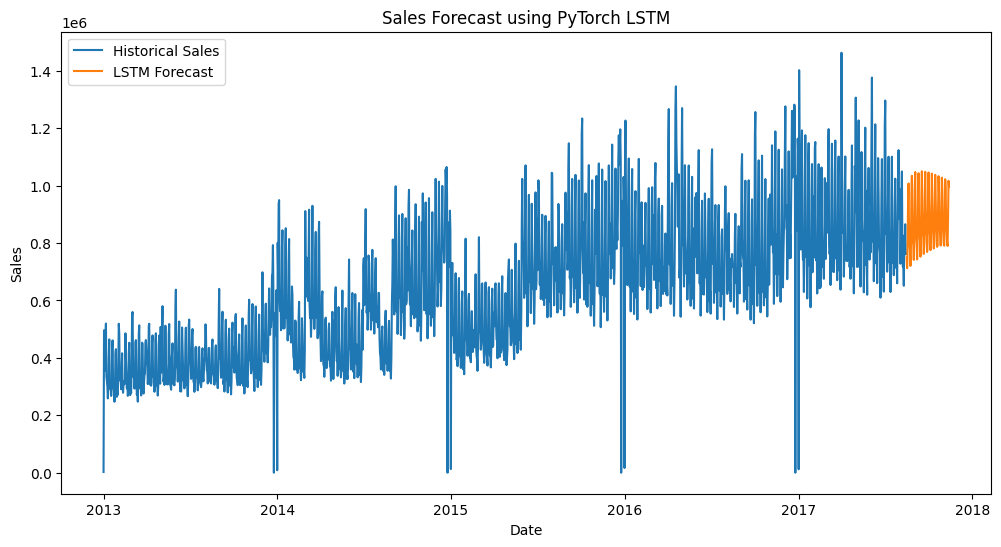

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
data_train = pd.read_csv('train.csv')
data_train['date'] = pd.to_datetime(data_train['date'])
data_train = data_train[['date', 'sales']].set_index('date')
data_train = data_train.resample('D').sum()  # Resample daily data

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_train)

# Convert data to supervised learning format
def create_sequences(data, sequence_length=30):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

sequence_length = 30  # Number of previous days to consider for prediction
x_train, y_train = create_sequences(data_scaled, sequence_length)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

# Create DataLoader
batch_size = 32
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last output for each sequence
        return out

# Instantiate the model, define loss function and optimizer
model = LSTM(input_size=1, hidden_size=50, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# Prepare the data for prediction
last_sequence = torch.from_numpy(data_scaled[-sequence_length:]).float().unsqueeze(0)

# Predict for the next 90 days
# Predict for the next 90 days
model.eval()
predictions = []
for _ in range(90):
    with torch.no_grad():
        next_prediction = model(last_sequence)
        predictions.append(next_prediction.item())

        # Update the sequence with the new prediction
        next_prediction = next_prediction.unsqueeze(1)  # Shape [batch_size, 1, features]
  # Shape [1, 1, 1] to match [batch, seq_length, features]
        last_sequence = torch.cat((last_sequence[:, 1:, :], next_prediction), dim=1)  # Concatenate along the sequence dimension

# Inverse scale the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train['sales'], label='Historical Sales')
future_dates = pd.date_range(data_train.index[-1] + pd.Timedelta(days=1), periods=90)
plt.plot(future_dates, predictions, label='LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast using PyTorch LSTM')
plt.legend()
plt.show()


In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        losses.append(epoch_loss / len(train_loader))
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {losses[-1]:.4f}')

    # Plot training loss over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()
    return model, losses


Epoch 10/50, Loss: 0.0052
Epoch 20/50, Loss: 0.0049
Epoch 30/50, Loss: 0.0046
Epoch 40/50, Loss: 0.0045
Epoch 50/50, Loss: 0.0043


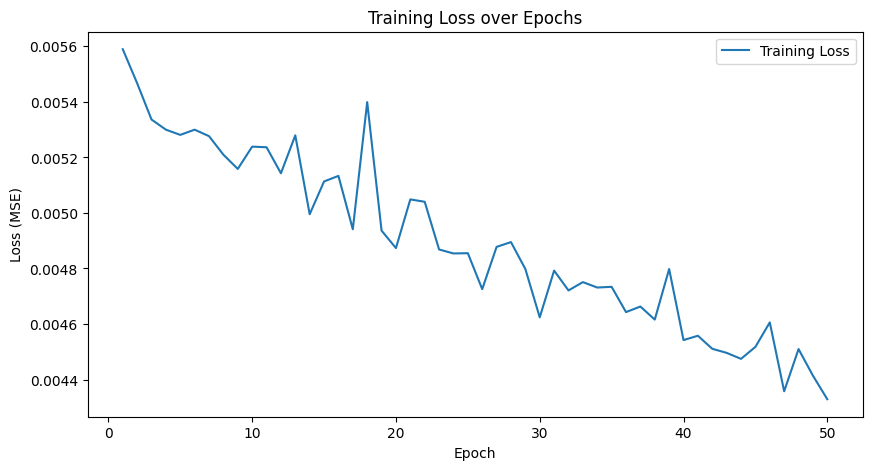

In [ ]:
model, losses = train_model(model, train_loader, criterion, optimizer, epochs=50)

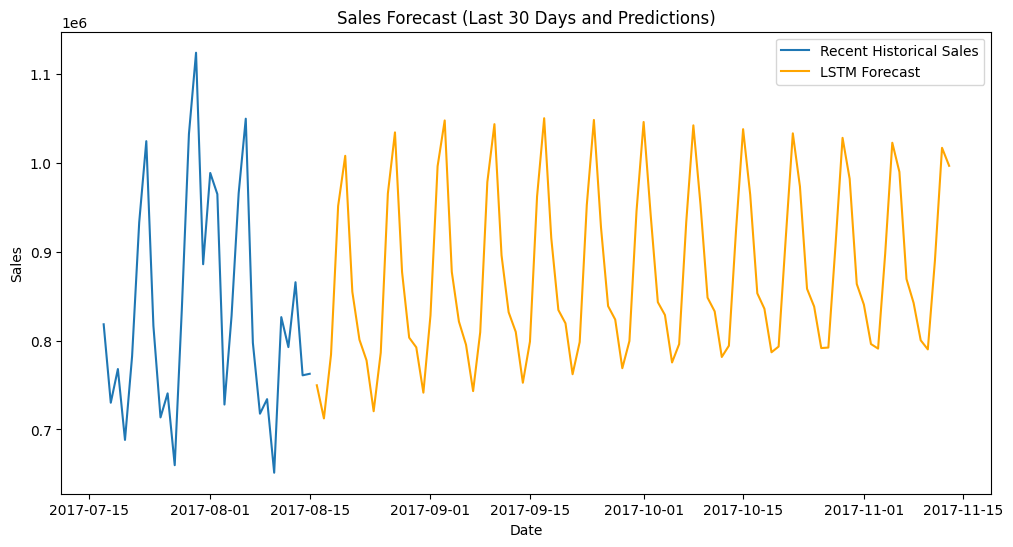

In [ ]:
# Plotting the zoomed-in results
plt.figure(figsize=(12, 6))
plt.plot(data_train.index[-30:], data_train['sales'][-30:], label='Recent Historical Sales')
plt.plot(future_dates, predictions, label='LSTM Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast (Last 30 Days and Predictions)')
plt.legend()
plt.show()


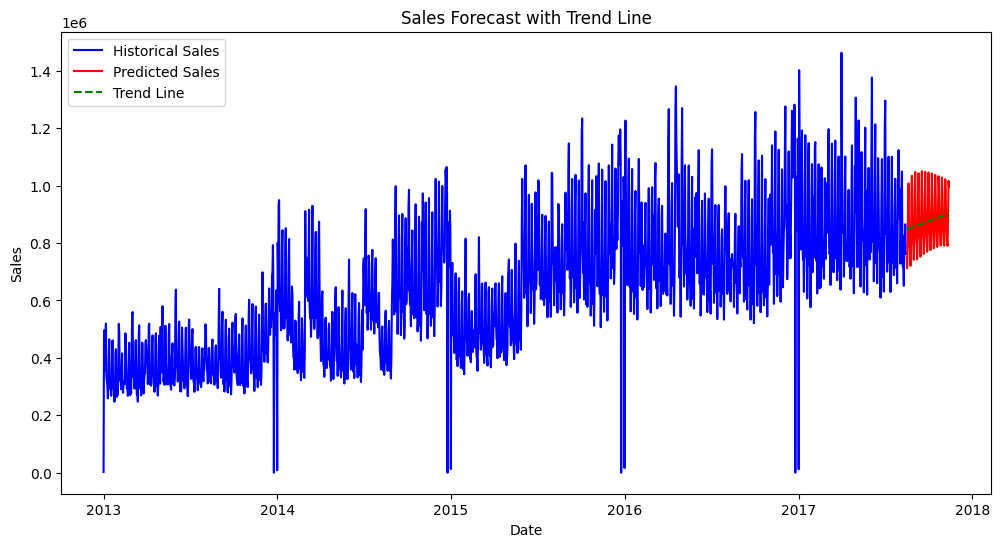

In [ ]:
# Plotting forecast with trend line
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train['sales'], label='Historical Sales', color='blue')
plt.plot(future_dates, predictions, label='Predicted Sales', color='red')

# Add a trend line (using a simple linear regression)
from sklearn.linear_model import LinearRegression

# Use a simple linear regression to fit a trend line to the predicted data
regressor = LinearRegression()
future_days = np.array(range(len(predictions))).reshape(-1, 1)  # Convert days to numerical values
regressor.fit(future_days, predictions)
trend_line = regressor.predict(future_days)

plt.plot(future_dates, trend_line, label='Trend Line', linestyle='--', color='green')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast with Trend Line')
plt.legend()
plt.show()


In [ ]:
print(data_train.columns)


Index(['sales'], dtype='object')


Epoch 10/50, Loss: 0.0124
Epoch 20/50, Loss: 0.0171
Epoch 30/50, Loss: 0.0018
Epoch 40/50, Loss: 0.0045
Epoch 50/50, Loss: 0.0027


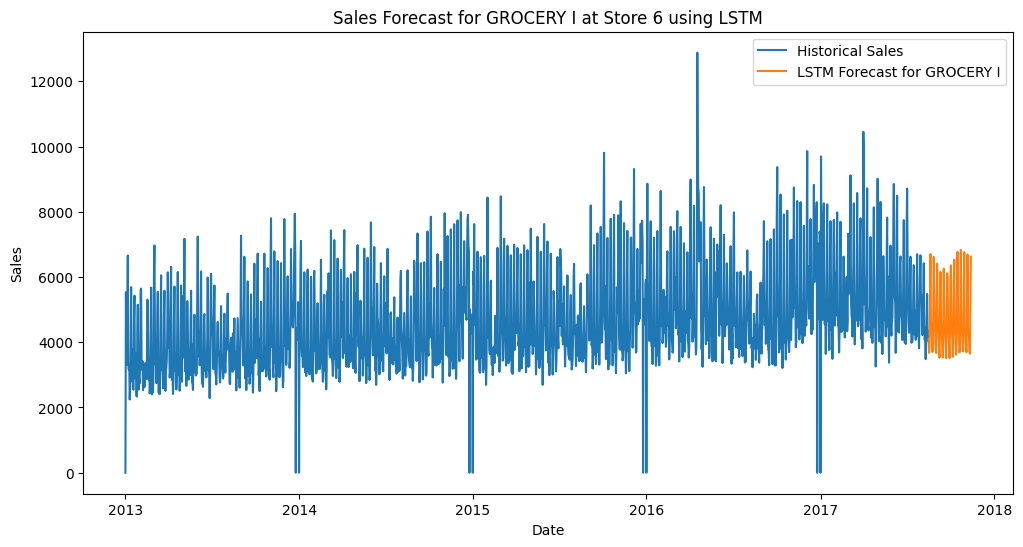

Predicted sales quantities for GROCERY I at Store 6 for the next 90 days:
Date: 2017-08-16, Predicted Sales: 4084.08
Date: 2017-08-17, Predicted Sales: 3674.45
Date: 2017-08-18, Predicted Sales: 3869.36
Date: 2017-08-19, Predicted Sales: 5221.04
Date: 2017-08-20, Predicted Sales: 6705.96
Date: 2017-08-21, Predicted Sales: 4609.11
Date: 2017-08-22, Predicted Sales: 4461.20
Date: 2017-08-23, Predicted Sales: 4222.71
Date: 2017-08-24, Predicted Sales: 3700.22
Date: 2017-08-25, Predicted Sales: 3765.88
Date: 2017-08-26, Predicted Sales: 5101.34
Date: 2017-08-27, Predicted Sales: 6617.02
Date: 2017-08-28, Predicted Sales: 5586.24
Date: 2017-08-29, Predicted Sales: 4656.99
Date: 2017-08-30, Predicted Sales: 4330.55
Date: 2017-08-31, Predicted Sales: 3809.56
Date: 2017-09-01, Predicted Sales: 3672.42
Date: 2017-09-02, Predicted Sales: 4853.28
Date: 2017-09-03, Predicted Sales: 6411.58
Date: 2017-09-04, Predicted Sales: 5102.76
Date: 2017-09-05, Predicted Sales: 4465.52
Date: 2017-09-06, Predi

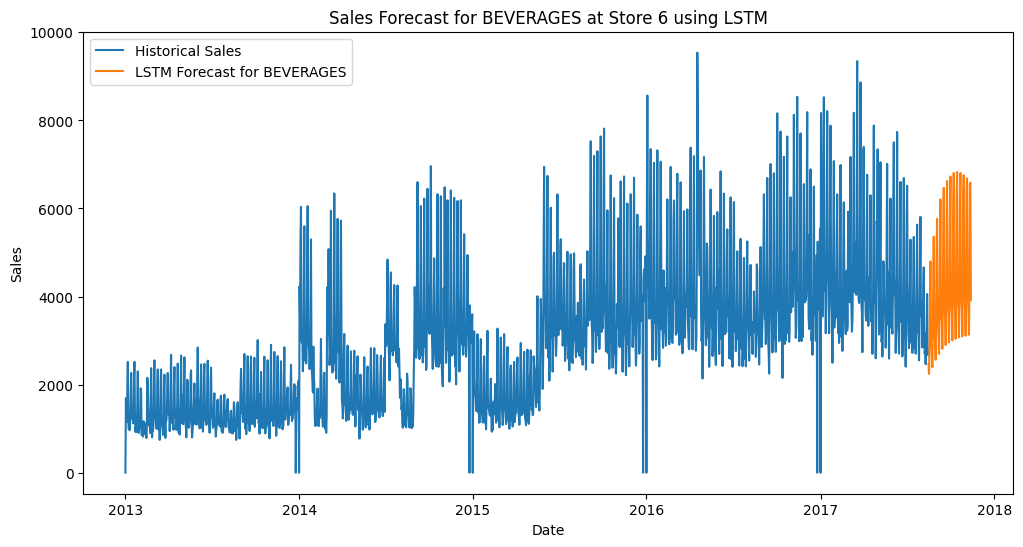

Predicted sales quantities for BEVERAGES at Store 6 for the next 90 days:
Date: 2017-08-16, Predicted Sales: 2464.43
Date: 2017-08-17, Predicted Sales: 2243.72
Date: 2017-08-18, Predicted Sales: 2857.74
Date: 2017-08-19, Predicted Sales: 4021.50
Date: 2017-08-20, Predicted Sales: 4798.14
Date: 2017-08-21, Predicted Sales: 3192.55
Date: 2017-08-22, Predicted Sales: 2928.56
Date: 2017-08-23, Predicted Sales: 2690.88
Date: 2017-08-24, Predicted Sales: 2394.63
Date: 2017-08-25, Predicted Sales: 3174.90
Date: 2017-08-26, Predicted Sales: 4522.93
Date: 2017-08-27, Predicted Sales: 5361.57
Date: 2017-08-28, Predicted Sales: 3371.29
Date: 2017-08-29, Predicted Sales: 3159.17
Date: 2017-08-30, Predicted Sales: 2870.00
Date: 2017-08-31, Predicted Sales: 2563.16
Date: 2017-09-01, Predicted Sales: 3483.19
Date: 2017-09-02, Predicted Sales: 4996.41
Date: 2017-09-03, Predicted Sales: 5763.90
Date: 2017-09-04, Predicted Sales: 3507.77
Date: 2017-09-05, Predicted Sales: 3428.32
Date: 2017-09-06, Predi

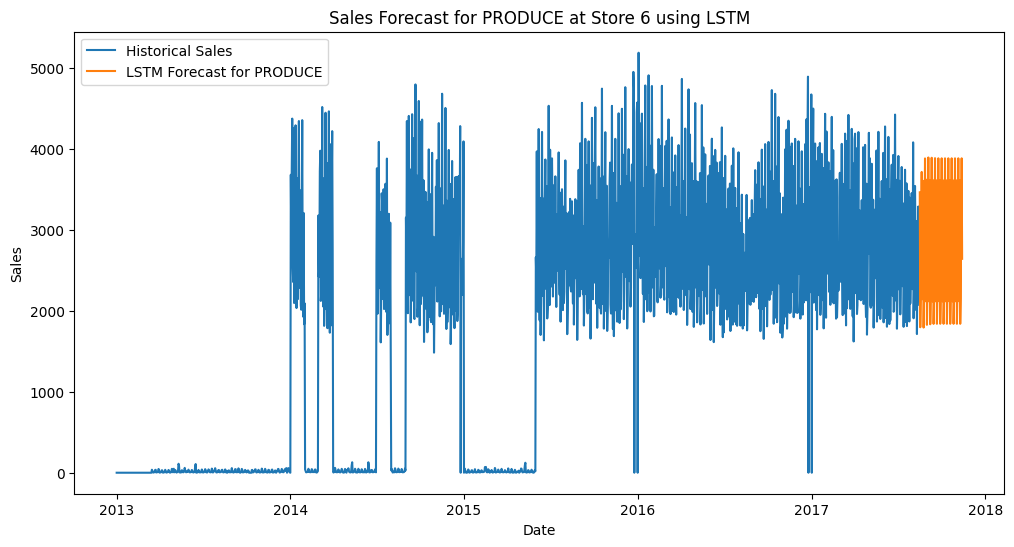

Predicted sales quantities for PRODUCE at Store 6 for the next 90 days:
Date: 2017-08-16, Predicted Sales: 3462.64
Date: 2017-08-17, Predicted Sales: 1796.27
Date: 2017-08-18, Predicted Sales: 2152.24
Date: 2017-08-19, Predicted Sales: 2925.00
Date: 2017-08-20, Predicted Sales: 3714.36
Date: 2017-08-21, Predicted Sales: 2626.63
Date: 2017-08-22, Predicted Sales: 2143.01
Date: 2017-08-23, Predicted Sales: 3604.43
Date: 2017-08-24, Predicted Sales: 1792.38
Date: 2017-08-25, Predicted Sales: 2235.97
Date: 2017-08-26, Predicted Sales: 3055.40
Date: 2017-08-27, Predicted Sales: 3881.23
Date: 2017-08-28, Predicted Sales: 2620.61
Date: 2017-08-29, Predicted Sales: 2116.45
Date: 2017-08-30, Predicted Sales: 3617.95
Date: 2017-08-31, Predicted Sales: 1826.15
Date: 2017-09-01, Predicted Sales: 2171.34
Date: 2017-09-02, Predicted Sales: 3033.79
Date: 2017-09-03, Predicted Sales: 3893.01
Date: 2017-09-04, Predicted Sales: 2634.24
Date: 2017-09-05, Predicted Sales: 2114.94
Date: 2017-09-06, Predict

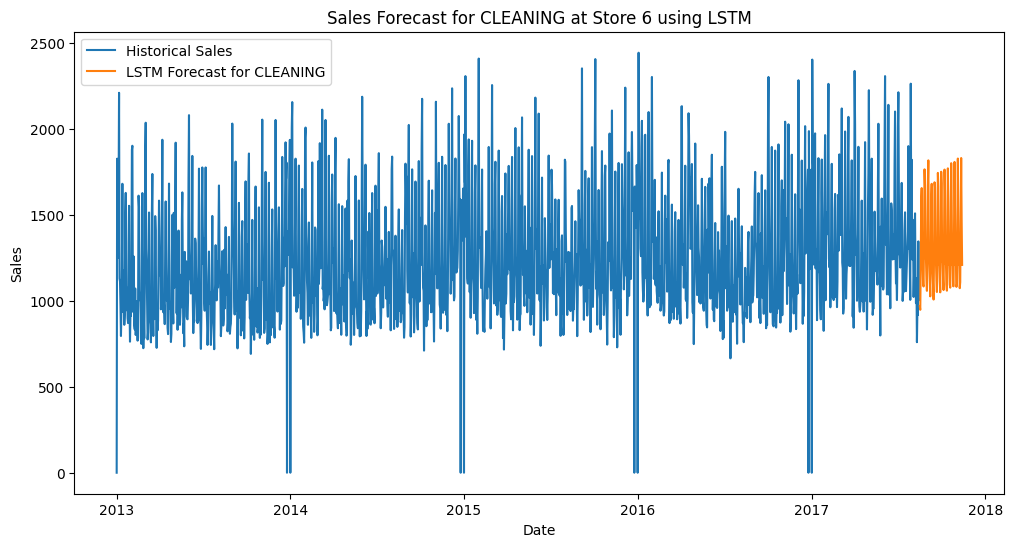

Predicted sales quantities for CLEANING at Store 6 for the next 90 days:
Date: 2017-08-16, Predicted Sales: 969.36
Date: 2017-08-17, Predicted Sales: 947.22
Date: 2017-08-18, Predicted Sales: 1201.00
Date: 2017-08-19, Predicted Sales: 1588.14
Date: 2017-08-20, Predicted Sales: 1655.06
Date: 2017-08-21, Predicted Sales: 1223.69
Date: 2017-08-22, Predicted Sales: 1216.22
Date: 2017-08-23, Predicted Sales: 1094.46
Date: 2017-08-24, Predicted Sales: 1082.83
Date: 2017-08-25, Predicted Sales: 1399.15
Date: 2017-08-26, Predicted Sales: 1763.97
Date: 2017-08-27, Predicted Sales: 1669.70
Date: 2017-08-28, Predicted Sales: 1248.89
Date: 2017-08-29, Predicted Sales: 1240.70
Date: 2017-08-30, Predicted Sales: 1127.52
Date: 2017-08-31, Predicted Sales: 1057.45
Date: 2017-09-01, Predicted Sales: 1299.80
Date: 2017-09-02, Predicted Sales: 1681.74
Date: 2017-09-03, Predicted Sales: 1816.21
Date: 2017-09-04, Predicted Sales: 1290.44
Date: 2017-09-05, Predicted Sales: 1219.86
Date: 2017-09-06, Predicte

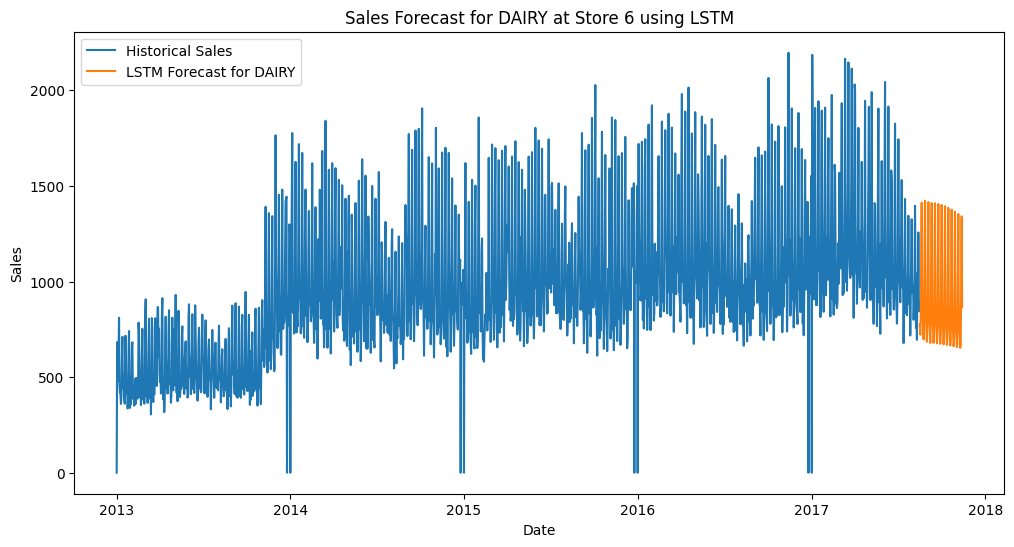

Predicted sales quantities for DAIRY at Store 6 for the next 90 days:
Date: 2017-08-16, Predicted Sales: 775.73
Date: 2017-08-17, Predicted Sales: 720.98
Date: 2017-08-18, Predicted Sales: 801.70
Date: 2017-08-19, Predicted Sales: 1113.49
Date: 2017-08-20, Predicted Sales: 1412.64
Date: 2017-08-21, Predicted Sales: 871.98
Date: 2017-08-22, Predicted Sales: 822.88
Date: 2017-08-23, Predicted Sales: 755.73
Date: 2017-08-24, Predicted Sales: 697.40
Date: 2017-08-25, Predicted Sales: 789.69
Date: 2017-08-26, Predicted Sales: 1124.48
Date: 2017-08-27, Predicted Sales: 1422.40
Date: 2017-08-28, Predicted Sales: 860.66
Date: 2017-08-29, Predicted Sales: 813.50
Date: 2017-08-30, Predicted Sales: 748.55
Date: 2017-08-31, Predicted Sales: 685.50
Date: 2017-09-01, Predicted Sales: 776.79
Date: 2017-09-02, Predicted Sales: 1125.58
Date: 2017-09-03, Predicted Sales: 1415.84
Date: 2017-09-04, Predicted Sales: 851.34
Date: 2017-09-05, Predicted Sales: 805.86
Date: 2017-09-06, Predicted Sales: 747.71


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
data_train = pd.read_csv('train.csv')
data_train['date'] = pd.to_datetime(data_train['date'])

# Select a store number (change to any store number you want)
store_selected = 6  # Example store number, change as needed

# Filter the data for the selected store
data_store = data_train[data_train['store_nbr'] == store_selected]

# Get the top 5 product families for the selected store based on total sales
top_5_families = data_store.groupby('family')['sales'].sum().nlargest(5).index

# Filter data for the selected store and top 5 product families
data_top_5_families = data_store[data_store['family'].isin(top_5_families)]

# Preprocess and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))

# Convert data to supervised learning format
def create_sequences(data, sequence_length=30):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last output for each sequence
        return out

# Prepare the data and model training for each product family
sequence_length = 30  # Number of previous days to consider for prediction
for family in top_5_families:
    # Filter the data for the current product family
    filtered_data = data_top_5_families[data_top_5_families['family'] == family]

    # Resample the data to daily frequency and sum the sales
    filtered_data = filtered_data[['date', 'sales']].set_index('date')
    filtered_data = filtered_data.resample('D').sum()  # Resample daily data

    # Scale the data
    data_scaled = scaler.fit_transform(filtered_data)

    # Create sequences
    x_train, y_train = create_sequences(data_scaled, sequence_length)

    # Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()

    # Create DataLoader
    batch_size = 32
    train_data = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    # Instantiate the model, define loss function and optimizer
    model = LSTM(input_size=1, hidden_size=50, num_layers=2, output_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    epochs = 50
    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    # Prepare the data for prediction
    last_sequence = torch.from_numpy(data_scaled[-sequence_length:]).float().unsqueeze(0)

    # Predict for the next 90 days
    model.eval()
    predictions = []
    for _ in range(90):
        with torch.no_grad():
            next_prediction = model(last_sequence)
            predictions.append(next_prediction.item())

            # Update the sequence with the new prediction
            next_prediction = next_prediction.unsqueeze(1)  # Shape [batch_size, 1, features]
            last_sequence = torch.cat((last_sequence[:, 1:, :], next_prediction), dim=1)

    # Inverse scale the predictions
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data.index, filtered_data['sales'], label='Historical Sales')

    # Generate future dates for the forecast
    future_dates = pd.date_range(filtered_data.index[-1] + pd.Timedelta(days=1), periods=90)
    plt.plot(future_dates, predictions, label=f'LSTM Forecast for {family}')

    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Sales Forecast for {family} at Store {store_selected} using LSTM')
    plt.legend()
    plt.show()

    # Print the predicted quantities for the next 90 days
    print(f"Predicted sales quantities for {family} at Store {store_selected} for the next 90 days:")
    for date, pred in zip(future_dates, predictions):
        print(f"Date: {date.date()}, Predicted Sales: {pred[0]:.2f}")


Epoch 10/50, Loss: 0.0070
Epoch 20/50, Loss: 0.0063
Epoch 30/50, Loss: 0.0020
Epoch 40/50, Loss: 0.0059
Epoch 50/50, Loss: 0.0014


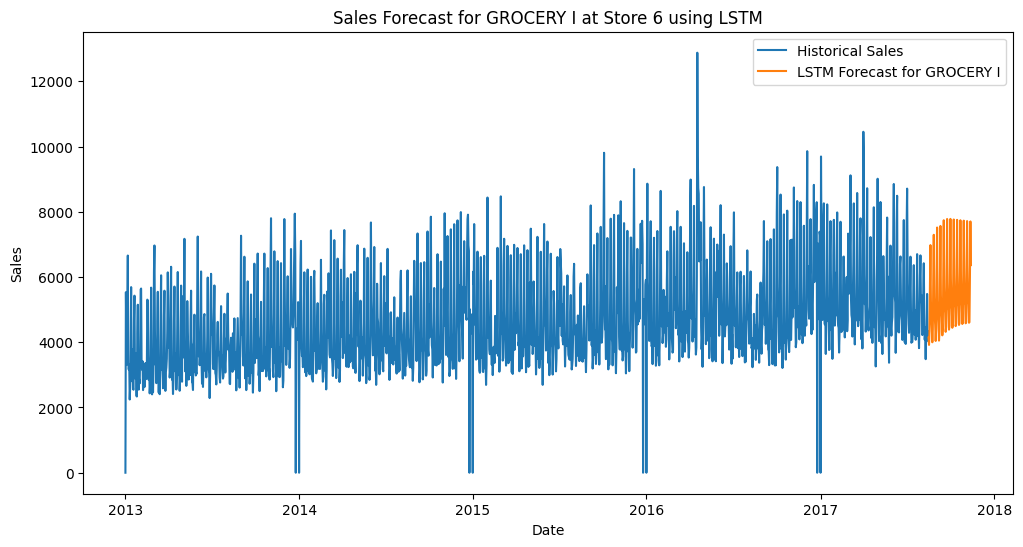

Predicted sales quantities for GROCERY I at Store 6 for the next 90 days:
Date: 2017-08-16, Predicted Sales: 4143.56
Date: 2017-08-17, Predicted Sales: 3919.35
Date: 2017-08-18, Predicted Sales: 4329.62
Date: 2017-08-19, Predicted Sales: 5789.84
Date: 2017-08-20, Predicted Sales: 6979.36
Date: 2017-08-21, Predicted Sales: 5270.15
Date: 2017-08-22, Predicted Sales: 4722.01
Date: 2017-08-23, Predicted Sales: 4416.47
Date: 2017-08-24, Predicted Sales: 3999.82
Date: 2017-08-25, Predicted Sales: 4388.13
Date: 2017-08-26, Predicted Sales: 6005.21
Date: 2017-08-27, Predicted Sales: 7295.17
Date: 2017-08-28, Predicted Sales: 5392.13
Date: 2017-08-29, Predicted Sales: 4814.91
Date: 2017-08-30, Predicted Sales: 4526.10
Date: 2017-08-31, Predicted Sales: 4040.48
Date: 2017-09-01, Predicted Sales: 4402.42
Date: 2017-09-02, Predicted Sales: 6112.53
Date: 2017-09-03, Predicted Sales: 7518.09
Date: 2017-09-04, Predicted Sales: 5283.11
Date: 2017-09-05, Predicted Sales: 4874.82
Date: 2017-09-06, Predi

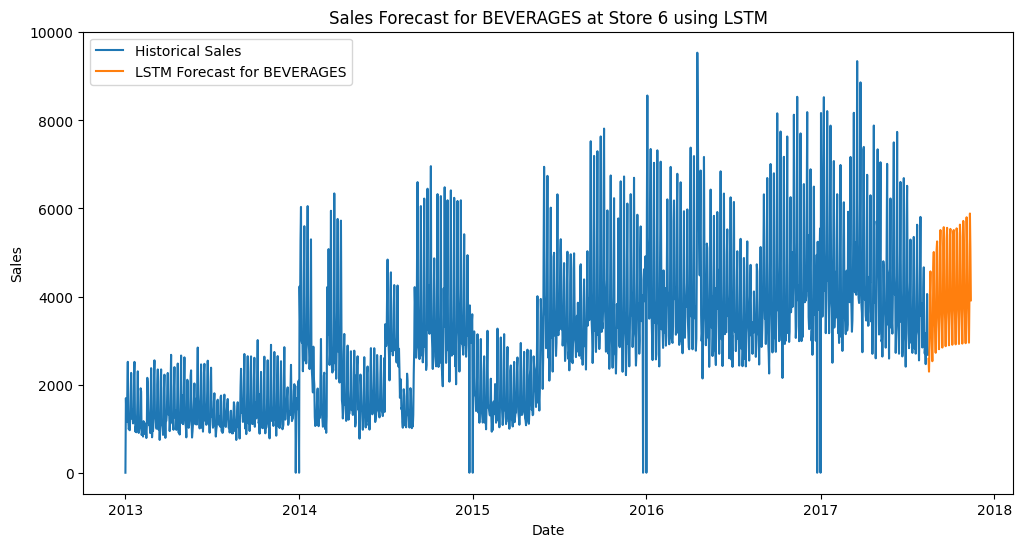

Predicted sales quantities for BEVERAGES at Store 6 for the next 90 days:
Date: 2017-08-16, Predicted Sales: 2583.11
Date: 2017-08-17, Predicted Sales: 2295.60
Date: 2017-08-18, Predicted Sales: 2879.20
Date: 2017-08-19, Predicted Sales: 4105.76
Date: 2017-08-20, Predicted Sales: 4570.96
Date: 2017-08-21, Predicted Sales: 3419.72
Date: 2017-08-22, Predicted Sales: 3243.62
Date: 2017-08-23, Predicted Sales: 2895.28
Date: 2017-08-24, Predicted Sales: 2532.27
Date: 2017-08-25, Predicted Sales: 3228.20
Date: 2017-08-26, Predicted Sales: 4644.14
Date: 2017-08-27, Predicted Sales: 5011.33
Date: 2017-08-28, Predicted Sales: 3680.72
Date: 2017-08-29, Predicted Sales: 3513.45
Date: 2017-08-30, Predicted Sales: 3155.21
Date: 2017-08-31, Predicted Sales: 2723.21
Date: 2017-09-01, Predicted Sales: 3499.32
Date: 2017-09-02, Predicted Sales: 5060.08
Date: 2017-09-03, Predicted Sales: 5252.47
Date: 2017-09-04, Predicted Sales: 3844.37
Date: 2017-09-05, Predicted Sales: 3680.50
Date: 2017-09-06, Predi

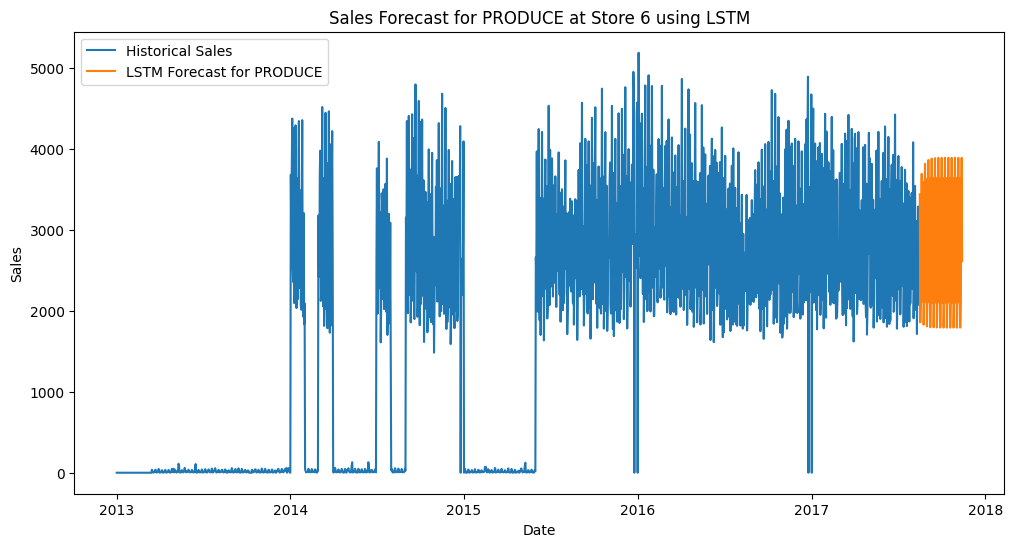

Predicted sales quantities for PRODUCE at Store 6 for the next 90 days:
Date: 2017-08-16, Predicted Sales: 3438.53
Date: 2017-08-17, Predicted Sales: 1856.86
Date: 2017-08-18, Predicted Sales: 2087.84
Date: 2017-08-19, Predicted Sales: 2937.42
Date: 2017-08-20, Predicted Sales: 3691.25
Date: 2017-08-21, Predicted Sales: 2543.49
Date: 2017-08-22, Predicted Sales: 2114.32
Date: 2017-08-23, Predicted Sales: 3592.20
Date: 2017-08-24, Predicted Sales: 1828.76
Date: 2017-08-25, Predicted Sales: 2110.67
Date: 2017-08-26, Predicted Sales: 2980.16
Date: 2017-08-27, Predicted Sales: 3813.85
Date: 2017-08-28, Predicted Sales: 2576.48
Date: 2017-08-29, Predicted Sales: 2106.68
Date: 2017-08-30, Predicted Sales: 3626.45
Date: 2017-08-31, Predicted Sales: 1807.38
Date: 2017-09-01, Predicted Sales: 2123.28
Date: 2017-09-02, Predicted Sales: 2992.61
Date: 2017-09-03, Predicted Sales: 3861.86
Date: 2017-09-04, Predicted Sales: 2597.05
Date: 2017-09-05, Predicted Sales: 2104.25
Date: 2017-09-06, Predict

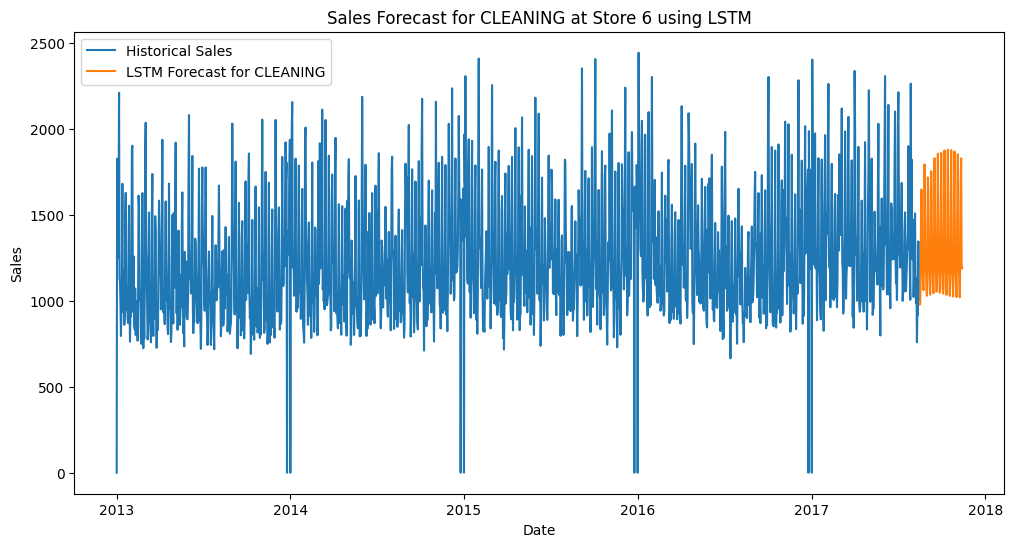

Predicted sales quantities for CLEANING at Store 6 for the next 90 days:
Date: 2017-08-16, Predicted Sales: 977.50
Date: 2017-08-17, Predicted Sales: 981.02
Date: 2017-08-18, Predicted Sales: 1214.96
Date: 2017-08-19, Predicted Sales: 1646.70
Date: 2017-08-20, Predicted Sales: 1640.57
Date: 2017-08-21, Predicted Sales: 1201.38
Date: 2017-08-22, Predicted Sales: 1174.73
Date: 2017-08-23, Predicted Sales: 1077.14
Date: 2017-08-24, Predicted Sales: 1061.57
Date: 2017-08-25, Predicted Sales: 1370.37
Date: 2017-08-26, Predicted Sales: 1792.76
Date: 2017-08-27, Predicted Sales: 1512.57
Date: 2017-08-28, Predicted Sales: 1186.02
Date: 2017-08-29, Predicted Sales: 1165.33
Date: 2017-08-30, Predicted Sales: 1069.76
Date: 2017-08-31, Predicted Sales: 1029.17
Date: 2017-09-01, Predicted Sales: 1280.46
Date: 2017-09-02, Predicted Sales: 1717.34
Date: 2017-09-03, Predicted Sales: 1633.03
Date: 2017-09-04, Predicted Sales: 1188.59
Date: 2017-09-05, Predicted Sales: 1172.93
Date: 2017-09-06, Predicte

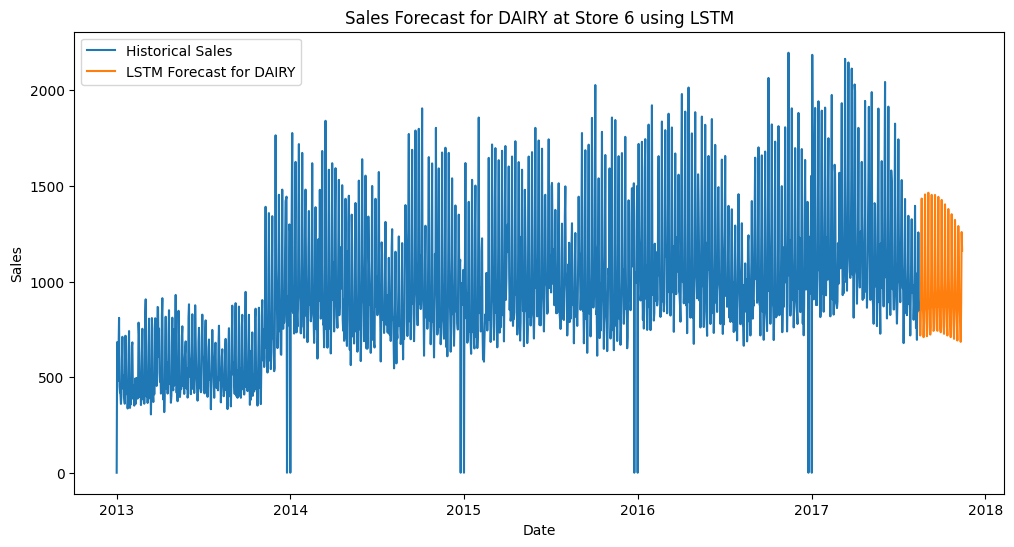

Predicted sales quantities for DAIRY at Store 6 for the next 90 days:
Date: 2017-08-16, Predicted Sales: 839.26
Date: 2017-08-17, Predicted Sales: 717.88
Date: 2017-08-18, Predicted Sales: 797.82
Date: 2017-08-19, Predicted Sales: 1095.16
Date: 2017-08-20, Predicted Sales: 1434.06
Date: 2017-08-21, Predicted Sales: 909.94
Date: 2017-08-22, Predicted Sales: 877.65
Date: 2017-08-23, Predicted Sales: 832.65
Date: 2017-08-24, Predicted Sales: 708.94
Date: 2017-08-25, Predicted Sales: 788.68
Date: 2017-08-26, Predicted Sales: 1099.47
Date: 2017-08-27, Predicted Sales: 1455.69
Date: 2017-08-28, Predicted Sales: 913.24
Date: 2017-08-29, Predicted Sales: 874.75
Date: 2017-08-30, Predicted Sales: 840.56
Date: 2017-08-31, Predicted Sales: 714.36
Date: 2017-09-01, Predicted Sales: 776.80
Date: 2017-09-02, Predicted Sales: 1094.20
Date: 2017-09-03, Predicted Sales: 1464.62
Date: 2017-09-04, Predicted Sales: 918.49
Date: 2017-09-05, Predicted Sales: 865.35
Date: 2017-09-06, Predicted Sales: 851.66


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
data_train = pd.read_csv('train.csv')
data_train['date'] = pd.to_datetime(data_train['date'])

# Select a store number (change to any store number you want)
store_selected = 6  # Example store number, change as needed

# Filter the data for the selected store
data_store = data_train[data_train['store_nbr'] == store_selected]

# Get the top 5 product families for the selected store based on total sales
top_5_families = data_store.groupby('family')['sales'].sum().nlargest(5).index

# Filter data for the selected store and top 5 product families
data_top_5_families = data_store[data_store['family'].isin(top_5_families)]

# Preprocess and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))

# Convert data to supervised learning format
def create_sequences(data, sequence_length=30):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last output for each sequence
        return out

# Prepare the data and model training for each product family
sequence_length = 30  # Number of previous days to consider for prediction
for family in top_5_families:
    # Filter the data for the current product family
    filtered_data = data_top_5_families[data_top_5_families['family'] == family]

    # Resample the data to daily frequency and sum the sales
    filtered_data = filtered_data[['date', 'sales']].set_index('date')
    filtered_data = filtered_data.resample('D').sum()  # Resample daily data

    # Scale the data
    data_scaled = scaler.fit_transform(filtered_data)

    # Create sequences
    x_train, y_train = create_sequences(data_scaled, sequence_length)

    # Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()

    # Create DataLoader
    batch_size = 32
    train_data = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    # Instantiate the model, define loss function and optimizer
    model = LSTM(input_size=1, hidden_size=50, num_layers=2, output_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    epochs = 50
    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    # Prepare the data for prediction
    last_sequence = torch.from_numpy(data_scaled[-sequence_length:]).float().unsqueeze(0)

    # Predict for the next 90 days
    model.eval()
    predictions = []
    for _ in range(90):
        with torch.no_grad():
            next_prediction = model(last_sequence)
            predictions.append(next_prediction.item())

            # Update the sequence with the new prediction
            next_prediction = next_prediction.unsqueeze(1)  # Shape [batch_size, 1, features]
            last_sequence = torch.cat((last_sequence[:, 1:, :], next_prediction), dim=1)

    # Inverse scale the predictions
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data.index, filtered_data['sales'], label='Historical Sales')

    # Generate future dates for the forecast
    future_dates = pd.date_range(filtered_data.index[-1] + pd.Timedelta(days=1), periods=90)
    plt.plot(future_dates, predictions, label=f'LSTM Forecast for {family}')

    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Sales Forecast for {family} at Store {store_selected} using LSTM')
    plt.legend()
    plt.show()

    # Print the predicted quantities for the next 90 days
    print(f"Predicted sales quantities for {family} at Store {store_selected} for the next 90 days:")
    for date, pred in zip(future_dates, predictions):
        print(f"Date: {date.date()}, Predicted Sales: {pred[0]:.2f}")


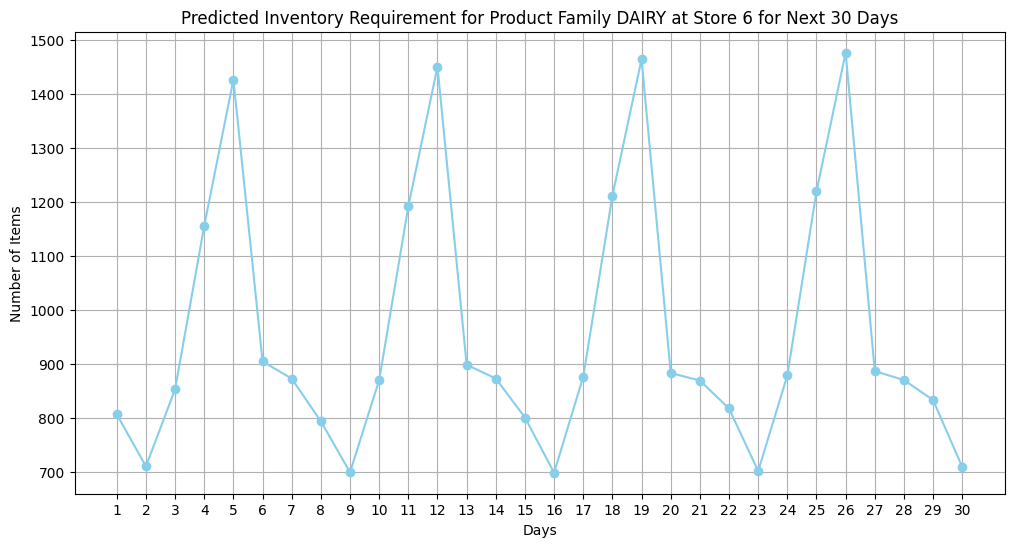

Predicted inventory required for Product Family DAIRY at Store 6 for the next 30 days:
Day 1: 806.81 items
Day 2: 710.47 items
Day 3: 853.51 items
Day 4: 1156.05 items
Day 5: 1426.38 items
Day 6: 904.89 items
Day 7: 872.88 items
Day 8: 793.88 items
Day 9: 699.68 items
Day 10: 870.28 items
Day 11: 1191.90 items
Day 12: 1450.42 items
Day 13: 898.63 items
Day 14: 873.15 items
Day 15: 800.99 items
Day 16: 698.81 items
Day 17: 876.59 items
Day 18: 1211.62 items
Day 19: 1464.10 items
Day 20: 883.36 items
Day 21: 869.43 items
Day 22: 817.69 items
Day 23: 701.73 items
Day 24: 878.90 items
Day 25: 1219.46 items
Day 26: 1476.13 items
Day 27: 886.85 items
Day 28: 870.36 items
Day 29: 833.32 items
Day 30: 709.24 items


In [ ]:
# Plotting the inventory required for the next 30 days for top 5 families
plt.figure(figsize=(12, 6))

# Create the x-axis as days (1 to 30)
days = np.arange(1, 31)

# Plot the predicted inventory required for the next 30 days
plt.plot(days, inventory_required, marker='o', color='skyblue', linestyle='-', markersize=6)

# Add titles and labels
plt.title(f'Predicted Inventory Requirement for Product Family {family} at Store {store_selected} for Next 30 Days')
plt.xlabel('Days')
plt.ylabel('Number of Items')
plt.xticks(days)  # Set the x-ticks to be each day (1-30)
plt.grid(True)

# Show the plot
plt.show()

# Print the predicted inventory required for the next 30 days
print(f"Predicted inventory required for Product Family {family} at Store {store_selected} for the next 30 days:")
for day, inv in zip(days, inventory_required):
    print(f"Day {day}: {inv:.2f} items")


Epoch 10/50, Loss: 0.0175
Epoch 20/50, Loss: 0.0074
Epoch 30/50, Loss: 0.0087
Epoch 40/50, Loss: 0.0028
Epoch 50/50, Loss: 0.0046
Epoch 10/50, Loss: 0.0064
Epoch 20/50, Loss: 0.0044
Epoch 30/50, Loss: 0.0102
Epoch 40/50, Loss: 0.0070
Epoch 50/50, Loss: 0.0080
Epoch 10/50, Loss: 0.0355
Epoch 20/50, Loss: 0.0268
Epoch 30/50, Loss: 0.0158
Epoch 40/50, Loss: 0.0051
Epoch 50/50, Loss: 0.0038
Epoch 10/50, Loss: 0.0133
Epoch 20/50, Loss: 0.0179
Epoch 30/50, Loss: 0.0149
Epoch 40/50, Loss: 0.0049
Epoch 50/50, Loss: 0.0055
Epoch 10/50, Loss: 0.0209
Epoch 20/50, Loss: 0.0128
Epoch 30/50, Loss: 0.0037
Epoch 40/50, Loss: 0.0069
Epoch 50/50, Loss: 0.0060


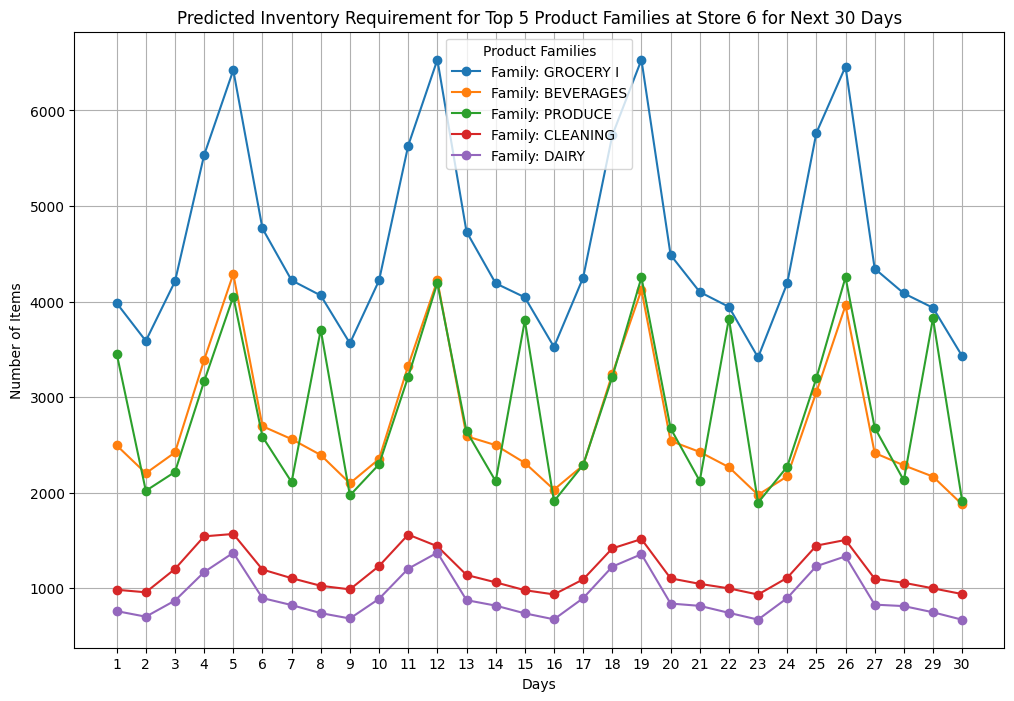

Predicted inventory required for Product Family GROCERY I at Store 6 for the next 30 days:
Day 1: 759.01 items
Day 2: 700.56 items
Day 3: 869.40 items
Day 4: 1167.38 items
Day 5: 1369.54 items
Day 6: 895.40 items
Day 7: 822.23 items
Day 8: 737.99 items
Day 9: 681.64 items
Day 10: 887.84 items
Day 11: 1203.09 items
Day 12: 1371.17 items
Day 13: 873.81 items
Day 14: 816.43 items
Day 15: 735.49 items
Day 16: 672.94 items
Day 17: 894.22 items
Day 18: 1224.32 items
Day 19: 1354.76 items
Day 20: 838.19 items
Day 21: 814.02 items
Day 22: 740.86 items
Day 23: 669.83 items
Day 24: 895.44 items
Day 25: 1229.06 items
Day 26: 1332.39 items
Day 27: 826.78 items
Day 28: 811.51 items
Day 29: 746.81 items
Day 30: 668.83 items
Predicted inventory required for Product Family BEVERAGES at Store 6 for the next 30 days:
Day 1: 759.01 items
Day 2: 700.56 items
Day 3: 869.40 items
Day 4: 1167.38 items
Day 5: 1369.54 items
Day 6: 895.40 items
Day 7: 822.23 items
Day 8: 737.99 items
Day 9: 681.64 items
Day 10:

In [ ]:
# Select the top 5 product families
top_5_families = top_20_families[:5]

# Plotting the inventory required for the next 30 days for the top 5 families
plt.figure(figsize=(12, 8))

# Create the x-axis as days (1 to 30)
days = np.arange(1, 31)

# Loop through the top 5 families
for i, family in enumerate(top_5_families):
    # Filter the data for the current product family
    filtered_data = data_top_20_families[data_top_20_families['family'] == family]

    # Resample the data to daily frequency and sum the sales
    filtered_data = filtered_data[['date', 'sales']].set_index('date')
    filtered_data = filtered_data.resample('D').sum()  # Resample to daily data

    # Scale the data
    data_scaled = scaler.fit_transform(filtered_data)

    # Create sequences
    x_train, y_train = create_sequences(data_scaled, sequence_length)

    # Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()

    # Create DataLoader
    train_data = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    # Instantiate the model, define loss function and optimizer
    model = LSTM(input_size=1, hidden_size=50, num_layers=2, output_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    epochs = 50
    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    # Prepare the data for prediction
    last_sequence = torch.from_numpy(data_scaled[-sequence_length:]).float().unsqueeze(0)

    # Predict for the next 30 days (one month)
    model.eval()
    predictions = []
    for _ in range(30):  # Predict for 30 days
        with torch.no_grad():
            next_prediction = model(last_sequence)
            predictions.append(next_prediction.item())

            # Update the sequence with the new prediction
            next_prediction = next_prediction.unsqueeze(1)  # Shape [batch_size, 1, features]
            last_sequence = torch.cat((last_sequence[:, 1:, :], next_prediction), dim=1)

    # Inverse scale the predictions
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Store the predicted sales for the product family (representing required inventory)
    inventory_required = predictions.flatten()

    # Plot the inventory required for the next 30 days for the current product family
    plt.plot(days, inventory_required, marker='o', label=f'Family: {family}', markersize=6)

# Add titles and labels
plt.title(f'Predicted Inventory Requirement for Top 5 Product Families at Store {store_selected} for Next 30 Days')
plt.xlabel('Days')
plt.ylabel('Number of Items')
plt.xticks(days)  # Set the x-ticks to be each day (1-30)
plt.grid(True)
plt.legend(title='Product Families')

# Show the plot
plt.show()

# Print the predicted inventory required for the next 30 days for each top 5 family
for family in top_5_families:
    print(f"Predicted inventory required for Product Family {family} at Store {store_selected} for the next 30 days:")
    for day, inv in zip(days, inventory_required):
        print(f"Day {day}: {inv:.2f} items")



Epoch 10/50, Loss: 0.0103
Epoch 20/50, Loss: 0.0147
Epoch 30/50, Loss: 0.0040
Epoch 40/50, Loss: 0.0031
Epoch 50/50, Loss: 0.0054
Mean Absolute Error (MAE): 59055.82
Mean Squared Error (MSE): 10128549108.79
Root Mean Squared Error (RMSE): 100640.69
R-squared (R²): 0.82
Mean Absolute Scaled Error (MASE): 0.49


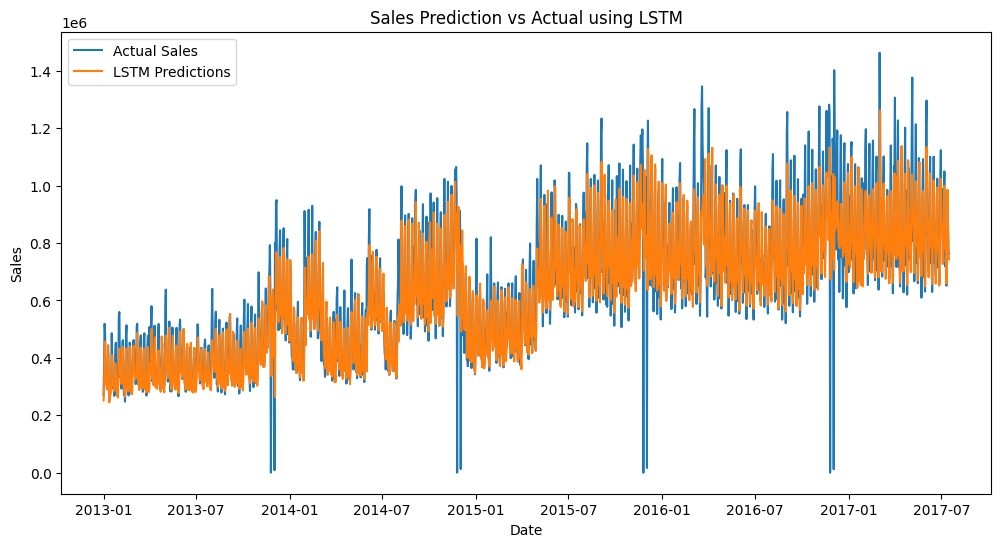

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
data_train = pd.read_csv('train.csv')
data_train['date'] = pd.to_datetime(data_train['date'])
data_train = data_train[['date', 'sales']].set_index('date')
data_train = data_train.resample('D').sum()  # Resample daily data

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_train)

# Convert data to supervised learning format
def create_sequences(data, sequence_length=30):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

sequence_length = 30  # Number of previous days to consider for prediction
x_train, y_train = create_sequences(data_scaled, sequence_length)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

# Create DataLoader
batch_size = 32
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last output for each sequence
        return out

# Instantiate the model, define loss function and optimizer
model = LSTM(input_size=1, hidden_size=50, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 50
for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# Predict using the trained model (evaluate on training data)
model.eval()
train_predictions = []
with torch.no_grad():
    for i in range(len(x_train)):
        prediction = model(x_train[i:i+1])  # Predict one batch at a time
        train_predictions.append(prediction.item())

train_predictions = np.array(train_predictions).flatten()

# Inverse scale the predictions and actual values
train_predictions_rescaled = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
y_train_rescaled = scaler.inverse_transform(y_train.numpy().reshape(-1, 1)).flatten()

# Error Metrics

def calculate_mase(actual, predicted, naive_actual):
    # Calculate MAE of naive forecast (previous value as the forecast)
    mae_naive = mean_absolute_error(actual[1:], naive_actual[1:])

    # Calculate MAE of the model
    mae_model = mean_absolute_error(actual, predicted)

    # Calculate MASE
    mase = mae_model / mae_naive
    return mase

# Naive Forecast: The naive forecast is simply the value from the previous day
naive_forecast = np.roll(y_train_rescaled, 1)
naive_forecast[0] = np.nan  # To avoid comparing the first value with a non-existing previous day

# MASE Calculation
mase = calculate_mase(y_train_rescaled, train_predictions_rescaled, naive_forecast)

# R² Calculation
r2 = r2_score(y_train_rescaled, train_predictions_rescaled)

# Print the results
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_train_rescaled, train_predictions_rescaled):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_train_rescaled, train_predictions_rescaled):.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_train_rescaled, train_predictions_rescaled)):.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data_train.index[:len(y_train_rescaled)], y_train_rescaled, label='Actual Sales')
plt.plot(data_train.index[:len(train_predictions_rescaled)], train_predictions_rescaled, label='LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Prediction vs Actual using LSTM')
plt.legend()
plt.show()
